In [2]:
## Import libraries
import warnings
import sys
import os
import gc
def clear_cache(cycle=3):
    for i in range(cycle):
        gc.collect()

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt

import multiprocessing as mp
import statsmodels.api as sm
from pmdarima.arima import auto_arima

import datetime as datetime
import itertools

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [3]:
## Forecasting configurations
max_orders_config = {
    'max_order_level' : 3,
    'max_order_diff' : 1,
    'max_seasonal_order_level' : 2,
    'max_seasonal_order_diff' : 1,
    'max_lags' : 7
}

order_grid_config = {
    'd':[i for i in range(max_orders_config['max_order_diff']+1)],
    'D':[i for i in range(max_orders_config['max_seasonal_order_diff']+1)]
}

list_all = [order_grid_config['d'], order_grid_config['D']]
combinations_all = [p for p in itertools.product(*list_all)]

train_percent, test_percent = 0.7, 0.3

In [4]:
data = pd.read_csv("Full_Dataset.csv")

In [5]:
time_var = 'date'
y_vars = [i for i in data.columns if "_y" in i]
x_vars = [i for i in data.columns if i not in y_vars+[time_var]]

In [6]:
test_limit = int(len(data)*test_percent) if int(len(data)*test_percent)>0 else 2
data.index = data[time_var]
data_train, data_test = data.iloc[:-test_limit,:], data.iloc[-test_limit:,:]

data_train.index, data_test.index = data_train[time_var], data_test[time_var]

In [7]:
all_results = {}
for y_no, y_i in enumerate(y_vars):
    data_i = data[[y_i]+x_vars].copy()
    endog_train, endog_test = data_train[[y_i]].copy(), data_test[[y_i]].copy()
    exog_train, exog_test = data_train[x_vars].copy(), data_test[x_vars].copy()
    
    best_aic = 999999999999999999
    best_model = {
        'group':y_i,
        'model':None,
        'test_error':None,
        'data':None        
    }
    
    best_order = None
    best_seasonal_order = None            
    for combi_no, combi_i in enumerate(combinations_all):
        sys.stdout.write("\rRunning for {}/{} - {}/{}                          ".format(
            y_no+1, len(y_vars),
            combi_no+1, len(combinations_all)
        ))
        sys.stdout.flush()
        try:
            stepwise_model = auto_arima(y=endog_train, 
                                        X=exog_train, 
                                        start_p=1, start_q=1,
                                        max_p=max_orders_config['max_order_level'], 
                                        max_q=max_orders_config['max_order_level'], 
                                        m=max_orders_config['max_lags'],
                                        start_P=0, 
                                        max_P=max_orders_config['max_seasonal_order_level'], 
                                        seasonal=True,
                                        start_Q=0, 
                                        max_Q=max_orders_config['max_seasonal_order_level'], 
                                        d=combi_i[0],D=combi_i[1],
                                        trace=False,
                                        error_action='ignore',
                                        suppress_warnings=True,
                                        stepwise=True)
            order_i = stepwise_model.order
            aic_i = stepwise_model.aic()
            seasonal_order_i = stepwise_model.seasonal_order

            if best_aic>aic_i:
                best_order = order_i
                best_seasonal_order = seasonal_order_i
        except:
            continue
            
    try:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order)                    
        results = model.fit(disp=0)
    except:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order,
                                         initialization='approximate_diffuse')                    
        results = model.fit(disp=0)

    data_i['predicted']=results.predict(start=0, end=len(data_i)-1, exog=exog_test).tolist()
    data_i['predicted_type'] = ['train']*len(data_train)+['test']*len(data_test)
    data_i['error'] = abs((data_i['predicted']-data_i[y_i])/data_i[y_i])
    test_error = data_i.groupby(['predicted_type']).agg({'error':'mean'})['error']['test']

    best_model['test_error'] = test_error
    best_model['data'] = data_i
    best_model['model'] = results   

    all_results[y_i] = best_model

Running for 5/5 - 4/4                          

In [8]:
parameters_df_all = pd.DataFrame()
for y_feat_no, y_feat_i in enumerate(all_results.keys()):
    parameters_df = pd.DataFrame(all_results[y_feat_i]['model'].params).reset_index()
    parameters_df.columns = ['Features','Coef']
    parameters_df['Coef_abs'] = abs(parameters_df['Coef'])
    parameters_df = parameters_df[
        parameters_df['Features'].isin(x_vars)
    ].copy().sort_values(['Coef_abs'],ascending=[True]).reset_index(drop=True)
    parameters_df['y_feature'] = y_feat_i
    parameters_df['error'] = all_results[y_feat_i]['test_error']
    
    parameters_df_all = parameters_df_all.append(parameters_df).reset_index(drop=True)
    
    parameters_df_pivot_i = parameters_df[['Features','Coef']].copy()
    parameters_df_pivot_i.columns = [(y_feat_i+'_{:.2%}'.format(all_results[y_feat_i]['test_error']), i) for i in parameters_df_pivot_i.columns]
    if y_feat_no == 0:
        parameters_df_pivot = parameters_df_pivot_i.copy()
    else:
        parameters_df_pivot = parameters_df_pivot.join(parameters_df_pivot_i)

In [9]:
parameters_df_pivot

,"(GME_y_75.25%, Features)","(GME_y_75.25%, Coef)","(TSLA_y_65.32%, Features)","(TSLA_y_65.32%, Coef)","(SPY_y_6.41%, Features)","(SPY_y_6.41%, Coef)","(^IXIC_y_6.81%, Features)","(^IXIC_y_6.81%, Coef)","(DJIA_y_12.36%, Features)","(DJIA_y_12.36%, Coef)"
0,investing_subscribers_avg,1.559381e-08,SecurityAnalysis_subscribers_avg,-0.000009,stocks_subscribers_avg,-0.000014,stocks_subscribers_avg,0.000354,investing_subscribers_avg,0.000330
1,num_comments,-1.284213e-06,num_comments,-0.000016,SecurityAnalysis_subscribers_avg,0.000030,num_comments,-0.000903,SecurityAnalysis_subscribers_avg,0.002943
2,SecurityAnalysis_subscribers_avg,-2.350957e-06,stocks_subscribers_avg,0.000021,investing_subscribers_avg,0.000038,SecurityAnalysis_subscribers_avg,0.001141,RobinHood_subscribers_avg,-0.003009
3,stocks_subscribers_avg,4.687603e-06,wallstreetbets_subscribers_avg,-0.000058,num_comments,-0.000049,RobinHood_subscribers_avg,-0.001193,stocks_subscribers_avg,-0.003088
4,RobinHood_subscribers_avg,-5.779517e-06,RobinHood_subscribers_avg,-0.000085,RobinHood_subscribers_avg,-0.000069,wallstreetbets_subscribers_avg,0.002132,num_comments,-0.004774
5,wallstreetbets_subscribers_avg,-1.409787e-05,investing_subscribers_avg,-0.000101,wallstreetbets_subscribers_avg,0.000213,investing_subscribers_avg,0.003063,wallstreetbets_subscribers_avg,0.017934
6,wallstreetbets_comment_avg,-1.551042e-04,wallstreetbets_score_avg,-0.004576,stocks_score_avg,-0.002503,RobinHood_score_avg,-0.089185,investing_score_avg,0.266659
7,investing_comment_avg,2.004135e-04,score,0.006221,score,0.005869,investing_score_avg,0.123995,score,0.420246
8,wallstreetbets_author_cnt,-3.749696e-04,investing_score_avg,0.006504,investing_score_avg,0.006472,score,0.193336,investing_id_cnt,-0.578601
9,score,-3.786871e-04,RobinHood_score_avg,-0.015132,wallstreetbets_comment_avg,0.007429,investing_author_cnt,-0.248183,wallstreetbets_score_avg,0.902210


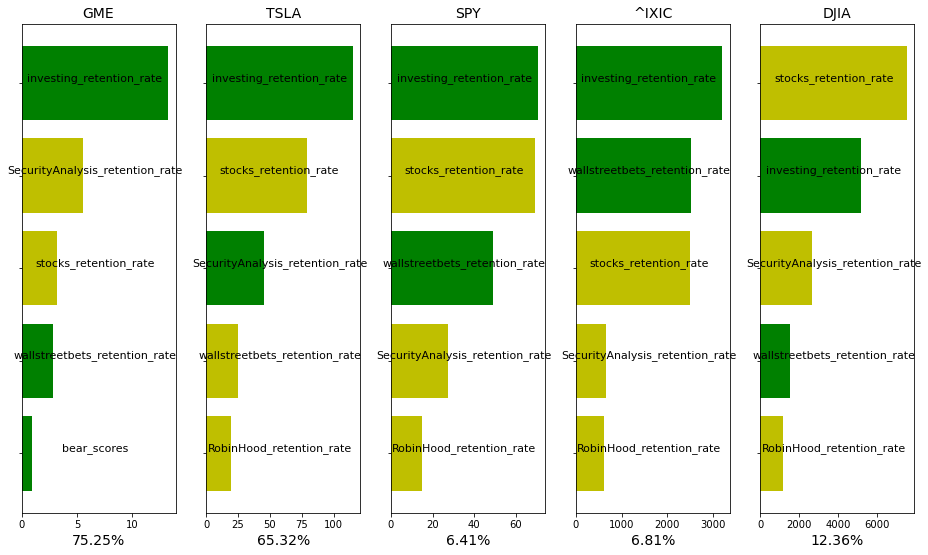

In [12]:
fig, ax = plt.subplots(1, len(y_vars), figsize=(16,9))

for y_no, y_i in enumerate(y_vars):
    
    y_current = [i[0] for i in parameters_df_pivot.columns if any(y_i in w for w in i)][0]
    
    importance_list = list(zip(parameters_df_pivot[(y_current, 'Features')][-5:], 
                               parameters_df_pivot[(y_current, 'Coef')][-5:]))

    colors = [('y' if i[1]<=0 else 'g') for i in importance_list]
    selected_list = parameters_df_pivot[(y_current, 'Features')][-5:]
    
    style_title = dict(size=14, color='black')
    ax[y_no].barh([i[0] for i in importance_list], [abs(i[1]) for i in importance_list], color=colors)
    ax[y_no].set_title(y_i.split("_")[0], **style_title)
    ax[y_no].set_yticklabels([])
    ax[y_no].set_xlabel(y_current.split("_")[2], **style_title)
    
    style = dict(size=11, color='black')
    rects = ax[y_no].patches
    best_width = max([i.get_width() for i in rects])/2
    labels = parameters_df_pivot[(y_current, 'Features')][-5:]
    for label_i, label in enumerate(labels):
#         height = rects.get_height()
        ax[y_no].text(best_width, label_i, label,
                ha='center', va='bottom', **style)

plt.show()

In [16]:
## Sentiment only
time_var = 'date'
y_vars = [i for i in data.columns if "_y" in i]
x_vars = [i for i in x_vars if '_score' in i and 'score_' not in i]

test_limit = int(len(data)*test_percent) if int(len(data)*test_percent)>0 else 2
data.index = data[time_var]
data_train, data_test = data.iloc[:-test_limit,:], data.iloc[-test_limit:,:]

data_train.index, data_test.index = data_train[time_var], data_test[time_var]

In [17]:
all_results_sentiment = {}
for y_no, y_i in enumerate(y_vars):
    data_i = data[[y_i]+x_vars].copy()
    endog_train, endog_test = data_train[[y_i]].copy(), data_test[[y_i]].copy()
    exog_train, exog_test = data_train[x_vars].copy(), data_test[x_vars].copy()
    
    best_aic = 999999999999999999
    best_model = {
        'group':y_i,
        'model':None,
        'test_error':None,
        'data':None        
    }
    
    best_order = None
    best_seasonal_order = None            
    for combi_no, combi_i in enumerate(combinations_all):
        sys.stdout.write("\rRunning for {}/{} - {}/{}                          ".format(
            y_no+1, len(y_vars),
            combi_no+1, len(combinations_all)
        ))
        sys.stdout.flush()
        try:
            stepwise_model = auto_arima(y=endog_train, 
                                        X=exog_train, 
                                        start_p=1, start_q=1,
                                        max_p=max_orders_config['max_order_level'], 
                                        max_q=max_orders_config['max_order_level'], 
                                        m=max_orders_config['max_lags'],
                                        start_P=0, 
                                        max_P=max_orders_config['max_seasonal_order_level'], 
                                        seasonal=True,
                                        start_Q=0, 
                                        max_Q=max_orders_config['max_seasonal_order_level'], 
                                        d=combi_i[0],D=combi_i[1],
                                        trace=False,
                                        error_action='ignore',
                                        suppress_warnings=True,
                                        stepwise=True)
            order_i = stepwise_model.order
            aic_i = stepwise_model.aic()
            seasonal_order_i = stepwise_model.seasonal_order

            if best_aic>aic_i:
                best_order = order_i
                best_seasonal_order = seasonal_order_i
        except:
            continue
            
    try:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order)                    
        results = model.fit(disp=0)
    except:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order,
                                         initialization='approximate_diffuse')                    
        results = model.fit(disp=0)

    data_i['predicted']=results.predict(start=0, end=len(data_i)-1, exog=exog_test).tolist()
    data_i['predicted_type'] = ['train']*len(data_train)+['test']*len(data_test)
    data_i['error'] = abs((data_i['predicted']-data_i[y_i])/data_i[y_i])
    test_error = data_i.groupby(['predicted_type']).agg({'error':'mean'})['error']['test']

    best_model['test_error'] = test_error
    best_model['data'] = data_i
    best_model['model'] = results   

    all_results_sentiment[y_i] = best_model

Running for 5/5 - 4/4                          

In [18]:
parameters_df_all_sentiment = pd.DataFrame()
for y_feat_no, y_feat_i in enumerate(all_results.keys()):
    parameters_df = pd.DataFrame(all_results_sentiment[y_feat_i]['model'].params).reset_index()
    parameters_df.columns = ['Features','Coef']
    parameters_df['Coef_abs'] = abs(parameters_df['Coef'])
    parameters_df = parameters_df[
        parameters_df['Features'].isin(x_vars)
    ].copy().sort_values(['Coef_abs'],ascending=[True]).reset_index(drop=True)
    parameters_df['y_feature'] = y_feat_i
    parameters_df['error'] = all_results_sentiment[y_feat_i]['test_error']
    
    parameters_df_all_sentiment = parameters_df_all_sentiment.append(parameters_df).reset_index(drop=True)
    
    parameters_df_pivot_i = parameters_df[['Features','Coef']].copy()
    parameters_df_pivot_i.columns = [(y_feat_i+'_{:.2%}'.format(all_results_sentiment[y_feat_i]['test_error']), i) for i in parameters_df_pivot_i.columns]
    if y_feat_no == 0:
        parameters_df_pivot_sentiment = parameters_df_pivot_i.copy()
    else:
        parameters_df_pivot_sentiment = parameters_df_pivot_sentiment.join(parameters_df_pivot_i)

In [19]:
parameters_df_pivot_sentiment

,"(GME_y_69.32%, Features)","(GME_y_69.32%, Coef)","(TSLA_y_72.19%, Features)","(TSLA_y_72.19%, Coef)","(SPY_y_1.70%, Features)","(SPY_y_1.70%, Coef)","(^IXIC_y_11.16%, Features)","(^IXIC_y_11.16%, Coef)","(DJIA_y_7.25%, Features)","(DJIA_y_7.25%, Coef)"
0,bull_scores,0.156197,sentiment_score,-1.865680,bear_scores,1.022711,bear_scores,39.836498,bear_scores,-194.360147
1,sentiment_score,0.531539,bull_scores,4.675895,sentiment_score,4.909967,bull_scores,105.616994,sentiment_score,330.863345
2,bear_scores,0.861181,bear_scores,-8.042121,bull_scores,6.429448,sentiment_score,190.544145,bull_scores,414.488381


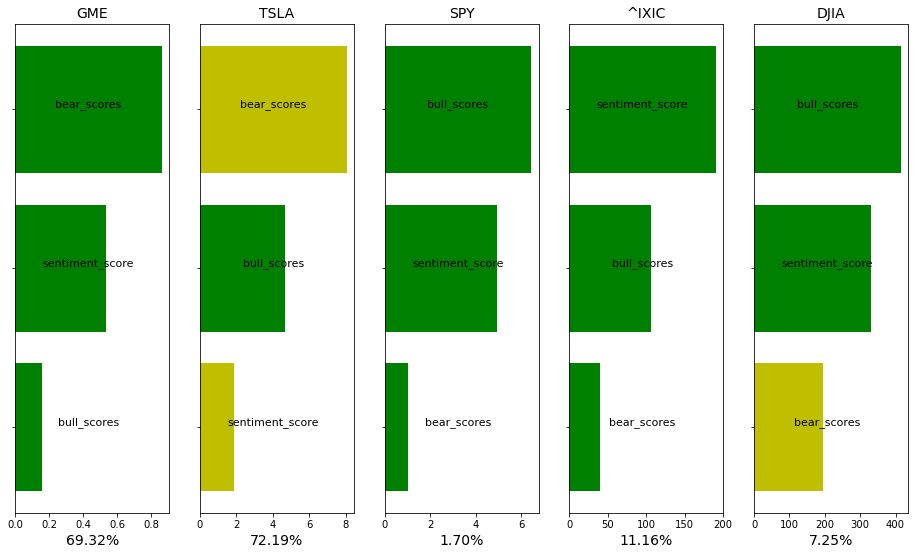

In [20]:
fig, ax = plt.subplots(1, len(y_vars), figsize=(16,9))

for y_no, y_i in enumerate(y_vars):
    
    y_current = [i[0] for i in parameters_df_pivot_sentiment.columns if any(y_i in w for w in i)][0]
    
    importance_list = list(zip(parameters_df_pivot_sentiment[(y_current, 'Features')][-5:], 
                               parameters_df_pivot_sentiment[(y_current, 'Coef')][-5:]))

    colors = [('y' if i[1]<=0 else 'g') for i in importance_list]
    selected_list = parameters_df_pivot_sentiment[(y_current, 'Features')][-5:]
    
    style_title = dict(size=14, color='black')
    ax[y_no].barh([i[0] for i in importance_list], [abs(i[1]) for i in importance_list], color=colors)
    ax[y_no].set_title(y_i.split("_")[0], **style_title)
    ax[y_no].set_yticklabels([])
    ax[y_no].set_xlabel(y_current.split("_")[2], **style_title)
    
    style = dict(size=11, color='black')
    rects = ax[y_no].patches
    best_width = max([i.get_width() for i in rects])/2
    labels = parameters_df_pivot_sentiment[(y_current, 'Features')][-5:]
    for label_i, label in enumerate(labels):
#         height = rects.get_height()
        ax[y_no].text(best_width, label_i, label,
                ha='center', va='bottom', **style)

plt.show()

In [29]:
## Networt only
time_var = 'date'
y_vars = [i for i in data.columns if "_y" in i]
x_vars = [w for w in data.columns if any(j in w for j in [i.split("_")[0] for i in data.columns if 'author' in i])]

test_limit = int(len(data)*test_percent) if int(len(data)*test_percent)>0 else 2
data.index = data[time_var]
data_train, data_test = data.iloc[:-test_limit,:], data.iloc[-test_limit:,:]

data_train.index, data_test.index = data_train[time_var], data_test[time_var]

In [30]:
all_results_network = {}
for y_no, y_i in enumerate(y_vars):
    data_i = data[[y_i]+x_vars].copy()
    endog_train, endog_test = data_train[[y_i]].copy(), data_test[[y_i]].copy()
    exog_train, exog_test = data_train[x_vars].copy(), data_test[x_vars].copy()
    
    best_aic = 999999999999999999
    best_model = {
        'group':y_i,
        'model':None,
        'test_error':None,
        'data':None        
    }
    
    best_order = None
    best_seasonal_order = None            
    for combi_no, combi_i in enumerate(combinations_all):
        sys.stdout.write("\rRunning for {}/{} - {}/{}                          ".format(
            y_no+1, len(y_vars),
            combi_no+1, len(combinations_all)
        ))
        sys.stdout.flush()
        try:
            stepwise_model = auto_arima(y=endog_train, 
                                        X=exog_train, 
                                        start_p=1, start_q=1,
                                        max_p=max_orders_config['max_order_level'], 
                                        max_q=max_orders_config['max_order_level'], 
                                        m=max_orders_config['max_lags'],
                                        start_P=0, 
                                        max_P=max_orders_config['max_seasonal_order_level'], 
                                        seasonal=True,
                                        start_Q=0, 
                                        max_Q=max_orders_config['max_seasonal_order_level'], 
                                        d=combi_i[0],D=combi_i[1],
                                        trace=False,
                                        error_action='ignore',
                                        suppress_warnings=True,
                                        stepwise=True)
            order_i = stepwise_model.order
            aic_i = stepwise_model.aic()
            seasonal_order_i = stepwise_model.seasonal_order

            if best_aic>aic_i:
                best_order = order_i
                best_seasonal_order = seasonal_order_i
        except:
            continue
            
    try:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order)                    
        results = model.fit(disp=0)
    except:
        model = sm.tsa.statespace.SARIMAX(endog_train, exog = exog_train,
                              order= best_order,seasonal_order=best_seasonal_order,
                                         initialization='approximate_diffuse')                    
        results = model.fit(disp=0)

    data_i['predicted']=results.predict(start=0, end=len(data_i)-1, exog=exog_test).tolist()
    data_i['predicted_type'] = ['train']*len(data_train)+['test']*len(data_test)
    data_i['error'] = abs((data_i['predicted']-data_i[y_i])/data_i[y_i])
    test_error = data_i.groupby(['predicted_type']).agg({'error':'mean'})['error']['test']

    best_model['test_error'] = test_error
    best_model['data'] = data_i
    best_model['model'] = results   

    all_results_network[y_i] = best_model

Running for 5/5 - 4/4                          

In [31]:
parameters_df_all_network = pd.DataFrame()
for y_feat_no, y_feat_i in enumerate(all_results.keys()):
    parameters_df = pd.DataFrame(all_results_network[y_feat_i]['model'].params).reset_index()
    parameters_df.columns = ['Features','Coef']
    parameters_df['Coef_abs'] = abs(parameters_df['Coef'])
    parameters_df = parameters_df[
        parameters_df['Features'].isin(x_vars)
    ].copy().sort_values(['Coef_abs'],ascending=[True]).reset_index(drop=True)
    parameters_df['y_feature'] = y_feat_i
    parameters_df['error'] = all_results_network[y_feat_i]['test_error']
    
    parameters_df_all_network = parameters_df_all_network.append(parameters_df).reset_index(drop=True)
    
    parameters_df_pivot_i = parameters_df[['Features','Coef']].copy()
    parameters_df_pivot_i.columns = [(y_feat_i+'_{:.2%}'.format(all_results_network[y_feat_i]['test_error']), i) for i in parameters_df_pivot_i.columns]
    if y_feat_no == 0:
        parameters_df_pivot_network = parameters_df_pivot_i.copy()
    else:
        parameters_df_pivot_network = parameters_df_pivot_network.join(parameters_df_pivot_i)

In [32]:
parameters_df_pivot_network

,"(GME_y_73.77%, Features)","(GME_y_73.77%, Coef)","(TSLA_y_66.34%, Features)","(TSLA_y_66.34%, Coef)","(SPY_y_4.04%, Features)","(SPY_y_4.04%, Coef)","(^IXIC_y_6.71%, Features)","(^IXIC_y_6.71%, Coef)","(DJIA_y_11.22%, Features)","(DJIA_y_11.22%, Coef)"
0,investing_subscribers_avg,-6.120774e-07,SecurityAnalysis_subscribers_avg,-0.000007,investing_subscribers_avg,0.000028,stocks_subscribers_avg,0.000223,RobinHood_subscribers_avg,0.000821
1,SecurityAnalysis_subscribers_avg,-1.373973e-06,stocks_subscribers_avg,0.000017,stocks_subscribers_avg,-0.000028,wallstreetbets_subscribers_avg,0.000531,investing_subscribers_avg,0.002000
2,stocks_subscribers_avg,4.113247e-06,RobinHood_subscribers_avg,-0.000088,SecurityAnalysis_subscribers_avg,0.000030,RobinHood_subscribers_avg,-0.000626,wallstreetbets_subscribers_avg,0.002020
3,RobinHood_subscribers_avg,-4.262412e-06,investing_subscribers_avg,-0.000099,RobinHood_subscribers_avg,-0.000057,SecurityAnalysis_subscribers_avg,0.001304,SecurityAnalysis_subscribers_avg,0.003083
4,wallstreetbets_subscribers_avg,-2.107445e-05,wallstreetbets_subscribers_avg,-0.000146,wallstreetbets_subscribers_avg,0.000075,investing_subscribers_avg,0.003216,stocks_subscribers_avg,-0.003224
5,wallstreetbets_author_cnt,-1.983390e-04,wallstreetbets_score_avg,0.000601,RobinHood_score_avg,0.000916,investing_score_avg,0.209496,investing_score_avg,0.265835
6,wallstreetbets_comment_avg,-3.742199e-04,investing_score_avg,0.007672,stocks_score_avg,-0.002793,RobinHood_score_avg,0.241955,investing_comment_avg,0.406617
7,wallstreetbets_score_avg,7.864750e-04,RobinHood_score_avg,-0.011904,RobinHood_id_cnt,0.005665,stocks_score_avg,0.275686,RobinHood_score_avg,-0.493904
8,SecurityAnalysis_score_avg,1.220086e-03,SecurityAnalysis_comment_avg,0.018486,investing_id_cnt,-0.006447,investing_id_cnt,-0.300588,RobinHood_id_cnt,0.529152
9,SecurityAnalysis_comment_avg,1.231455e-03,stocks_comment_avg,-0.022740,investing_score_avg,0.008508,RobinHood_author_cnt,0.355771,investing_id_cnt,0.650868


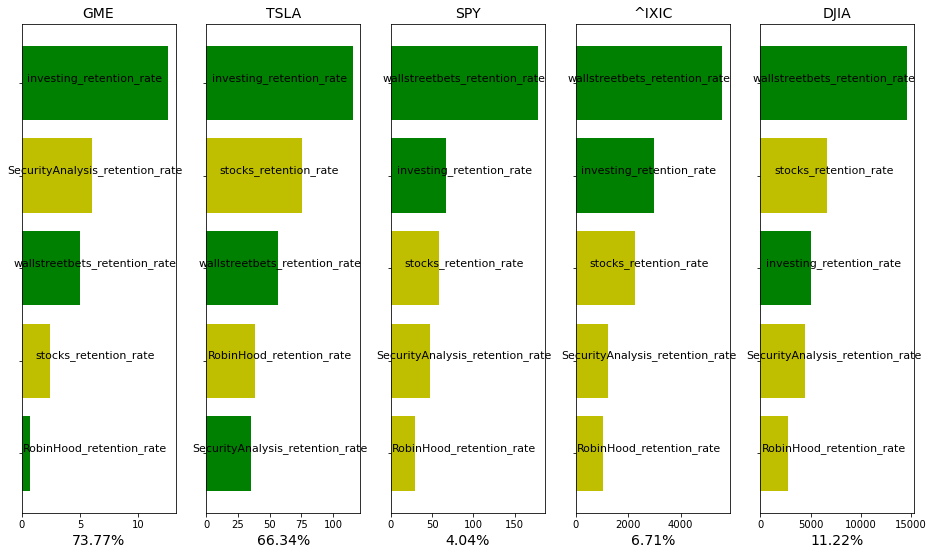

In [33]:
fig, ax = plt.subplots(1, len(y_vars), figsize=(16,9))

for y_no, y_i in enumerate(y_vars):
    
    y_current = [i[0] for i in parameters_df_pivot_network.columns if any(y_i in w for w in i)][0]
    
    importance_list = list(zip(parameters_df_pivot_network[(y_current, 'Features')][-5:], 
                               parameters_df_pivot_network[(y_current, 'Coef')][-5:]))

    colors = [('y' if i[1]<=0 else 'g') for i in importance_list]
    selected_list = parameters_df_pivot_network[(y_current, 'Features')][-5:]
    
    style_title = dict(size=14, color='black')
    ax[y_no].barh([i[0] for i in importance_list], [abs(i[1]) for i in importance_list], color=colors)
    ax[y_no].set_title(y_i.split("_")[0], **style_title)
    ax[y_no].set_yticklabels([])
    ax[y_no].set_xlabel(y_current.split("_")[2], **style_title)
    
    style = dict(size=11, color='black')
    rects = ax[y_no].patches
    best_width = max([i.get_width() for i in rects])/2
    labels = parameters_df_pivot_network[(y_current, 'Features')][-5:]
    for label_i, label in enumerate(labels):
#         height = rects.get_height()
        ax[y_no].text(best_width, label_i, label,
                ha='center', va='bottom', **style)

plt.show()